In [1]:
#@title SVHN
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


In [2]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

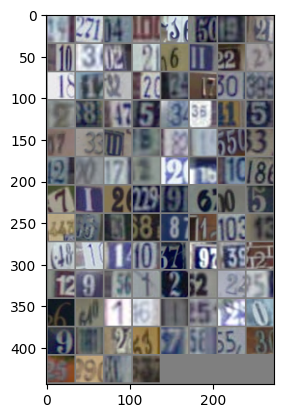

Labels: 9 7 4 0 1 5 9 2 1 3 2 2 6 1 2 2 1 1 2 2 2 1 0 9 2 8 4 5 3 6 1 5 0 3 1 8 8 1 5 3 2 0 7 2 2 1 1 8 7 1 2 2 9 6 0 5 4 5 3 8 8 1 0 1 4 1 1 0 7 9 3 2 1 9 5 1 2 2 2 5 6 4 1 6 1 5 2 0 9 8 2 3 7 8 5 3 5 9 0 3


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and labels
imshow(torchvision.utils.make_grid(images))
print("Labels:", " ".join(f"{labels[j].item()}" for j in range(batch_size)))

In [4]:
# Load a single batch from the data loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Print the shapes of images and labels
print("Images shape:", images.shape)  # Shape: (batch_size, num_channels, height, width)
print("Labels shape:", labels.shape)  # Shape: (batch_size,)

Images shape: torch.Size([100, 3, 32, 32])
Labels shape: torch.Size([100])


### Images

In [ ]:
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)



# Show images
imshow(torchvision.utils.make_grid(images))

### title NCSNv2Deeper 


In [4]:
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch
from functools import partial
#from . import get_sigmas
from layers import *
from normalization import get_normalization

In [5]:
# title NCSNv2Deeper 

class NCSNv2Deeper(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.logit_transform = config.data.logit_transform
        self.rescaled = config.data.rescaled
        self.norm = get_normalization(config, conditional=False)
        self.ngf = ngf = config.model.ngf
        self.num_classes = config.model.num_classes
        self.act = act = get_act(config)
        self.register_buffer('sigmas', get_sigmas(config))
        self.config = config
        

        self.begin_conv = nn.Conv2d(config.data.channels, ngf, 3, stride=1, padding=1)
        self.normalizer = self.norm(ngf, self.num_classes)

        self.end_conv = nn.Conv2d(ngf, config.data.channels, 3, stride=1, padding=1)

        self.res1 = nn.ModuleList([
            ResidualBlock(self.ngf, self.ngf, resample=None, act=act,
                          normalization=self.norm),
            ResidualBlock(self.ngf, self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res2 = nn.ModuleList([
            ResidualBlock(self.ngf, 2 * self.ngf, resample='down', act=act,
                          normalization=self.norm),
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res3 = nn.ModuleList([
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample='down', act=act,
                          normalization=self.norm),
            ResidualBlock(2 * self.ngf, 2 * self.ngf, resample=None, act=act,
                          normalization=self.norm)]
        )

        self.res4 = nn.ModuleList([
            ResidualBlock(2 * self.ngf, 4 * self.ngf, resample='down', act=act,
                          normalization=self.norm, dilation=2),
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample=None, act=act,
                          normalization=self.norm, dilation=2)]
        )

        self.res5 = nn.ModuleList([
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample='down', act=act,
                          normalization=self.norm, dilation=4),
            ResidualBlock(4 * self.ngf, 4 * self.ngf, resample=None, act=act,
                          normalization=self.norm, dilation=4)]
        )

        self.refine1 = RefineBlock([4 * self.ngf], 4 * self.ngf, act=act, start=True)
        self.refine2 = RefineBlock([4 * self.ngf, 4 * self.ngf], 2 * self.ngf, act=act)
        self.refine3 = RefineBlock([2 * self.ngf, 2 * self.ngf], 2 * self.ngf, act=act)
        self.refine4 = RefineBlock([2 * self.ngf, 2 * self.ngf], self.ngf, act=act)
        self.refine5 = RefineBlock([self.ngf, self.ngf], self.ngf, act=act, end=True)

    def _compute_cond_module(self, module, x):
        for m in module:
            x = m(x)
        return x

    def forward(self, x, y):
        if not self.logit_transform and not self.rescaled:
            h = 2 * x - 1.
        else:
            h = x

        output = self.begin_conv(h)

        layer1 = self._compute_cond_module(self.res1, output)
        layer2 = self._compute_cond_module(self.res2, layer1)
        layer3 = self._compute_cond_module(self.res3, layer2)
        layer4 = self._compute_cond_module(self.res4, layer3)
        layer5 = self._compute_cond_module(self.res5, layer4)

        ref1 = self.refine1([layer5], layer5.shape[2:])
        ref2 = self.refine2([layer4, ref1], layer4.shape[2:])
        ref3 = self.refine3([layer3, ref2], layer3.shape[2:])
        ref4 = self.refine4([layer2, ref3], layer2.shape[2:])
        output = self.refine5([layer1, ref4], layer1.shape[2:])

        output = self.normalizer(output)
        output = self.act(output)
        output = self.end_conv(output)

        used_sigmas = self.sigmas[y].view(x.shape[0], *([1] * len(x.shape[1:])))

        output = output / used_sigmas

        return output


### Class config

In [6]:
import yaml

# Load the YAML file as a dictionary
with open("configs.yml", "r") as file:
    config_dict = yaml.safe_load(file)

# Access the elements of the dictionary using dot notation
class Config:
    def __init__(self, d):
        self.training = Config.Training(d["training"])
        self.sampling = Config.Sampling(d["sampling"])
        self.fast_fid = Config.FastFID(d["fast_fid"])
        self.test = Config.Test(d["test"])
        self.data = Config.Data(d["data"])
        self.model = Config.Model(d["model"])
        self.optim = Config.Optim(d["optim"])
    class Training:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.n_epochs = d["n_epochs"]
            self.n_iters = d["n_iters"]
            self.snapshot_freq = d["snapshot_freq"]
            self.snapshot_sampling = d["snapshot_sampling"]
            self.anneal_power = d["anneal_power"]
            self.log_all_sigmas = d["log_all_sigmas"]

    class Sampling:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.data_init = d["data_init"]
            self.step_lr = d["step_lr"]
            self.n_steps_each = d["n_steps_each"]
            self.ckpt_id = d["ckpt_id"]
            self.final_only = d["final_only"]
            self.fid = d["fid"]
            self.denoise = d["denoise"]
            self.num_samples4fid = d["num_samples4fid"]
            self.inpainting = d["inpainting"]
            self.interpolation = d["interpolation"]
            self.n_interpolations = d["n_interpolations"]

    class FastFID:
        def __init__(self, d):
            self.batch_size = d["batch_size"]
            self.num_samples = d["num_samples"]
            self.step_lr = d["step_lr"]
            self.n_steps_each = d["n_steps_each"]
            self.begin_ckpt = d["begin_ckpt"]
            self.end_ckpt = d["end_ckpt"]
            self.verbose = d["verbose"]
            self.ensemble = d["ensemble"]

    class Test:
        def __init__(self, d):
            self.begin_ckpt = d["begin_ckpt"]
            self.end_ckpt = d["end_ckpt"]
            self.batch_size = d["batch_size"]

    class Data:
        def __init__(self, d):
            self.dataset = d["dataset"]
            self.image_size = d["image_size"]
            self.channels = d["channels"]
            self.logit_transform = d["logit_transform"]
            self.uniform_dequantization = d["uniform_dequantization"]
            self.gaussian_dequantization = d["gaussian_dequantization"]
            self.random_flip = d["random_flip"]
            self.rescaled = d["rescaled"]
            self.num_workers = d["num_workers"]

    class Model:
        def __init__(self, d):
            self.sigma_begin = d["sigma_begin"]
            self.num_classes = d["num_classes"]
            self.ema = d["ema"]
            self.ema_rate = d["ema_rate"]
            self.spec_norm = d["spec_norm"]
            self.sigma_dist = d["sigma_dist"]
            self.sigma_end = d["sigma_end"]
            self.normalization = d["normalization"]
            self.nonlinearity = d["nonlinearity"]
            self.ngf = d["ngf"]

    class Optim:
        def __init__(self, d):
            self.weight_decay = d["weight_decay"]
            self.optimizer = d["optimizer"]
            self.lr = d["lr"]
            self.beta1 = d["beta1"]
            self.amsgrad = d["amsgrad"]
            self.eps = d["eps"]

    


# Create a config object
config = Config(config_dict)




In [10]:

model = NCSNv2Deeper(config)

num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")



Number of trainable parameters: 83445379


### title Defining a time-dependent score-based model

In [29]:
### title Defining a time-dependent score-based model

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, padding=1, bias=False) # 3 , padding=1
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, padding=1, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, padding=1, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, padding=1, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, padding=1,  bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, padding=1,  output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 3, 3, stride=1, padding=1) # 3
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# Instantiate the model with example marginal_prob_std function
marginal_prob_std = lambda t: torch.ones(t.shape[0])
model = ScoreNet(marginal_prob_std)

# Calculate the number of trainable parameters
num_trainable_params = count_parameters(model)
print("Number of trainable parameters:", num_trainable_params)

Number of trainable parameters: 1117027


### title Set up the SDE

In [31]:
#@title Set up the SDE
import functools

from functools import partial, reduce


device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma =  10.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

### Loss        

In [55]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [8]:
def anneal_dsm_score_estimation(scorenet, samples, sigmas, labels=None, anneal_power=2., hook=None):
    if labels is None:
        labels = torch.randint(0, len(sigmas), (samples.shape[0],), device=samples.device)
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    noise = torch.randn_like(samples) * used_sigmas
    perturbed_samples = samples + noise
    target = - 1 / (used_sigmas ** 2) * noise
    scores = scorenet(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power

    if hook is not None:
        hook(loss, labels)

    return loss.mean(dim=0)

In [15]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import numpy as np
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
subset_size = 2000  # The number of samples you want in the subset
indices = np.random.choice(len(train_dataset), subset_size, replace=False)
svhn_train_subset = Subset(train_dataset, indices)

dataloader = DataLoader(svhn_train_subset, batch_size=64, shuffle=True, num_workers=4)

#### Sigmas

In [9]:
def get_sigmas(config):
    if config.model.sigma_dist == 'geometric':
        sigmas = torch.tensor(
            np.exp(np.linspace(np.log(config.model.sigma_begin), np.log(config.model.sigma_end),
                               config.model.num_classes))).float()#.to(config.device)
    elif config.model.sigma_dist == 'uniform':
        sigmas = torch.tensor(
            np.linspace(config.model.sigma_begin, config.model.sigma_end, config.model.num_classes)
        ).float()#.to(config.device)

    else:
        raise NotImplementedError('sigma distribution not supported')

    return sigmas

### Training

In [59]:
sigmas = get_sigmas(config)

In [44]:
len(sigmas)

232

In [16]:
import torch
from torch.optim import Adam

# Instantiate the model
model = NCSNv2Deeper(config)

# Move the model to the desired device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the optimizer
optimizer = Adam(model.parameters(), lr=config.optim.lr)

# Define the number of training epochs
n_epochs = config.training.n_epochs

# Define the sigmas
sigmas = get_sigmas(config)

In [17]:


# Training loop
for epoch in range(n_epochs):
    for batch_idx, (data, labels) in enumerate(dataloader):
        # Move data and labels to the desired device
        data = data.to(device)
        labels = labels.to(device)

        # Forward pass: compute the scores from the model
        optimizer.zero_grad()
        loss = anneal_dsm_score_estimation(model, data, sigmas, labels, anneal_power=config.training.anneal_power)

        # Backward pass: compute the gradient of the loss with respect to the model's parameters
        loss.backward()

        # Update the model's parameters
        optimizer.step()

        # Print the current training progress
        print(f"Epoch: {epoch + 1}/{n_epochs}, Batch: {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item()}")

# Save the trained model
torch.save(model.state_dict(), "trained_model.pth")


Epoch: 1/5, Batch: 1/32, Loss: 2675.667236328125
Epoch: 1/5, Batch: 2/32, Loss: 1999.861083984375
Epoch: 1/5, Batch: 3/32, Loss: 1742.4207763671875
Epoch: 1/5, Batch: 4/32, Loss: 1336.0264892578125
Epoch: 1/5, Batch: 5/32, Loss: 1091.17529296875
Epoch: 1/5, Batch: 6/32, Loss: 995.9505004882812
Epoch: 1/5, Batch: 7/32, Loss: 881.1590576171875
Epoch: 1/5, Batch: 8/32, Loss: 744.9468383789062
Epoch: 1/5, Batch: 9/32, Loss: 618.9122314453125
Epoch: 1/5, Batch: 10/32, Loss: 515.4614868164062
Epoch: 1/5, Batch: 11/32, Loss: 438.0440368652344
Epoch: 1/5, Batch: 12/32, Loss: 369.6677551269531
Epoch: 1/5, Batch: 13/32, Loss: 314.0317077636719
Epoch: 1/5, Batch: 14/32, Loss: 273.01495361328125
Epoch: 1/5, Batch: 15/32, Loss: 239.725341796875
Epoch: 1/5, Batch: 16/32, Loss: 212.91127014160156
Epoch: 1/5, Batch: 17/32, Loss: 192.93890380859375
Epoch: 1/5, Batch: 18/32, Loss: 179.3148193359375
Epoch: 1/5, Batch: 19/32, Loss: 166.2711181640625
Epoch: 1/5, Batch: 20/32, Loss: 153.00189208984375
Epoch

In [ ]:
#@title Training (double click to expand or collapse)

import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import tqdm
from tqdm.notebook import trange



score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}


optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

In [18]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

In [19]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=32, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda', 
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation 
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 3, 224, 224, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

In [23]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
#device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('trained_model.pth')  # , map_location=device
NCSNv2Deeper.load_state_dict(ckpt)

sample_batch_size = 4 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(NCSNv2Deeper, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size) #, 
                  #device=device

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt

sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)), padding=2, pad_value=1)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

TypeError: Module.load_state_dict() missing 1 required positional argument: 'state_dict'